In [2]:
from google.colab import files
uploaded = files.upload()

Saving IR_data_news_12k.zip to IR_data_news_12k.zip


In [3]:
import zipfile
with zipfile.ZipFile('IR_data_news_12k.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
import pandas as pd

In [ ]:
import json
f = open('IR_data_news_12k.json')
data = json.load(f)
#check
for i in range(1000):
  print(data[str(i)]['title'])

print(len(data))
f.close()

In [ ]:
!pip3 install parsivar

In [ ]:
!pip install hazm

**libraries**

In [8]:
from parsivar import Normalizer, Tokenizer, FindStems
from hazm import stopwords_list

Preprocessing

In [9]:
my_normalizer = Normalizer()
my_tokenizer = Tokenizer()


def normalize_data(data):
  norm_data = {}
  for i in range(len(data)):
    norm_data[str(i)] = my_normalizer.normalize(data[str(i)]['content'])
  return norm_data

def get_tokens(data):
  tokenized_data = {}
  for i in range(len(data)):
    tokenized_data[str(i)] = my_tokenizer.tokenize_words(data[str(i)])
  return tokenized_data

normalized_data = normalize_data(data)
tokenized_data = get_tokens(normalized_data)



---



In [10]:
stopwords = stopwords_list()
stopwords += ['.', '،', ':', '/', ')', '(', '%', '//', '[', ']', 'و', 'های', 'ها']

def remove_stopwords(data):
  removed_data = {}
  for i in range(len(data)):
    removed_data[str(i)] = [word for word in data[str(i)] if word not in stopwords]
  return removed_data

removed_data = remove_stopwords(tokenized_data)

Stemmer

In [11]:
my_stemmer = FindStems()

def stem_words(data):
  stem = {}
  for i in range(len(data)):
    words = []
    for word in data[str(i)]:
      words.append(my_stemmer.convert_to_stem(word))
    stem[str(i)] = words
  return stem

stem_data = stem_words(removed_data)

Positional Index

In [12]:
pos_index = {}
doc_id = 0

def positional_index(data):
  for doc_id, content in data.items():
    for pos, term in enumerate(content):
      #check if we have it already
      if term in pos_index:

        if doc_id in pos_index[term][1]:
          # pos_index[term][1][doc_id][1].append(pos)
          pos_index[term][1][doc_id][0] += 1
        else:
          pos_index[term][1][doc_id] = []
          pos_index[term][1][doc_id].append(1)
          # pos_index[term][1][doc_id].append([pos])
        
        pos_index[term][0] += 1

      else:
        pos_index[term] = []
        pos_index[term].append(1)
        pos_index[term].append({})
        pos_index[term][1][doc_id] = []
        pos_index[term][1][doc_id].append(1)
        # pos_index[term][1][doc_id].append([pos])

  return pos_index

pos_in = positional_index(stem_data)
print(len(pos_in))
# print(pos_in["فایزر"])

57469


**Phase 2**

vectorizing documents

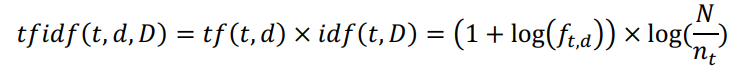

In [13]:

import math
import copy
new_in = copy.deepcopy(pos_in)

saved_pos_in = {}
tf_idf = 0

def update_positional_index(pos):
  for term in pos.keys():
    for doc in pos[term][1].keys():
      tf_idf = (1 + math.log10(pos[term][1][doc][0])) * math.log10(len(data)//len(pos[term][1]))
      pos[term][1][doc].append(tf_idf)
  return pos

weighted_index = update_positional_index(new_in)

**Champion List**



In [14]:
import copy
champion_list = copy.deepcopy(weighted_index)
for term in champion_list.keys():
  champion_list[term][1] = dict(sorted(champion_list[term][1].items(), key=lambda item: item[1][1],reverse=True))
  if len(champion_list[term][1]) > 100:
    for i in range(0,len(champion_list[term][1]) - 100):
      k, v = champion_list[term][1].popitem()

**phase 2**

query processing

In [ ]:
import re
import functools
from hazm import *
import math 
hazm_normalizer = Normalizer()


import heapq

def query_proc():
  query = input()

  normal_queries = []
  words = query.split(" ")


  normal_queries = [w for w in words]
  

  # preprocess query
  for w in normal_queries:
    w = my_normalizer.normalize(w)
    w = my_tokenizer.tokenize_words(w)
  for i in range(len(normal_queries)):
    normal_queries = [word for word in normal_queries if word not in stopwords]
    
  new_words = []
  for w in normal_queries:  
    new_words.append(my_stemmer.convert_to_stem(w))
  normal_queries = new_words
  # print(normal_queries)

# phase 2

# calculate term frequency in query
  def countFrequency(my_list):
      freq = {}
      for item in my_list:
          if (item in freq):
              freq[item] += 1
          else:
              freq[item] = 1
      return freq    

  # weight calculation with index elimination
  def cosine_score(query, weighted_index):
    w = 0
    result = []
    scores = [0] * len(data)
    length = [0] * len(data)
    tf = countFrequency(query)

    for t in query:
      w = (1 + math.log10(tf[t])) * math.log10(len(data)//len(weighted_index[t][1]))
      for doc in weighted_index[t][1].keys():
        scores[int(doc)] += weighted_index[t][1][doc][1] * w

    for d in range(len(scores)):
      if scores[d] != 0:
        for w in set(stem_data[str(d)]):
          if str(d) in weighted_index[w][1]:
            length[d] += (weighted_index[w][1][str(d)][1] ** 2)
        scores[d] = scores[d] / math.sqrt(length[d])


    # choose first k (=5)
    k = 5
    h_scores = scores[:]
    heapq.heapify(h_scores)
    highest_scores = heapq.nlargest(k, h_scores)
    for s in highest_scores:
      result.append(scores.index(s))

    return result

  results = cosine_score(normal_queries, weighted_index)
  results2 = cosine_score(normal_queries, champion_list)

  # for doc in range(len(results)):
  #     print(data[str(results[doc])]['title'])
  #     print(data[str(results[doc])]['url'])
  #     print(str(results[doc]))
  print("____________________________________________")

  for doc in range(len(results2)):
      print(data[str(results2[doc])]['title'])
      print(data[str(results2[doc])]['url'])
      # print(str(results2[doc]))

query_proc()